# JSONL dosyasını beklenen formata çevir

In [1]:
import json

input_file = "../data/raw/dataset.jsonl"
output_file = "../data/processed/dataset_formatted.jsonl"

with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
    for line in infile:
        data = json.loads(line)
        formatted = {
            "text": data["text"],
            "label": data["sub_tag"]
        }
        outfile.write(json.dumps(formatted, ensure_ascii=False) + "\n")


# PDFs klasörü içindeki pdflerin metnini çıkart

In [2]:
%pip install PyMuPDF   


     ---------------------------------------- 0.0/18.7 MB ? eta -:--:--
     --------------------------------------- 0.0/18.7 MB 640.0 kB/s eta 0:00:30
     --------------------------------------- 0.1/18.7 MB 656.4 kB/s eta 0:00:29
     --------------------------------------- 0.1/18.7 MB 837.8 kB/s eta 0:00:23
      --------------------------------------- 0.2/18.7 MB 1.4 MB/s eta 0:00:13
     - -------------------------------------- 0.5/18.7 MB 2.3 MB/s eta 0:00:09
     - -------------------------------------- 0.5/18.7 MB 2.3 MB/s eta 0:00:09
     - -------------------------------------- 0.9/18.7 MB 3.2 MB/s eta 0:00:06
     -- ------------------------------------- 1.3/18.7 MB 3.8 MB/s eta 0:00:05
     --- ------------------------------------ 1.6/18.7 MB 4.0 MB/s eta 0:00:05
     ---- ----------------------------------- 1.9/18.7 MB 4.4 MB/s eta 0:00:04
     ---- ----------------------------------- 2.3/18.7 MB 4.6 MB/s eta 0:00:04
     ----- ---------------------------------- 2.6/18.7 


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import fitz  # PyMuPDF
import json
import os

pdf_folder = "../data/raw/PDFs"  # PDF dosyalarının olduğu klasör
output_file = "../data/processed/pdf_dataset.jsonl"

pdf_count = 0  # PDF sayacı

with open(output_file, "w", encoding="utf-8") as outfile:
    for filename in os.listdir(pdf_folder):
        if filename.lower().endswith(".pdf"):
            pdf_path = os.path.join(pdf_folder, filename)
            doc = fitz.open(pdf_path)
            full_text = ""
            for page in doc:
                full_text += page.get_text()
            doc.close()
            
            pdf_count += 1  # PDF sayısını artır
            
            # JSONL kaydı
            record = {
                "text": full_text,
                "label": ""  # Şimdilik boş bırakıyoruz
            }
            outfile.write(json.dumps(record, ensure_ascii=False) + "\n")

print(f"Toplam {pdf_count} PDF işlendi.")


Toplam 100 PDF işlendi.


# pdf_dataset.jsonl dosyasıdaki metinleri temizle

In [4]:
# PDF metinlerini temizlemek için fonksiyon
import re

def clean_text(text):
    """PDF'den çıkarılan metinleri temizler"""
    
    # Boş metin kontrolü
    if not text or text.strip() == "":
        return ""
    
    # 1. Fazla boşlukları ve satır sonlarını temizle
    text = re.sub(r'\n+', ' ', text)  # Birden fazla \n'i tek boşlukla değiştir
    text = re.sub(r'\s+', ' ', text)  # Birden fazla boşluğu tek boşlukla değiştir
    
    # 2. Sayfa numaralarını kaldır (tek başına duran sayılar)
    text = re.sub(r'\b\d+/\d+\b', '', text)  # "2/2", "3/4" gibi
    text = re.sub(r'^\d+\s*$', '', text, flags=re.MULTILINE)  # Tek başına sayılar
    
    # 3. Dosya numaralarını kaldır
    text = re.sub(r'\d{2}-\d{2}/\d{3}-\d{3}', '', text)  # "07-75/898-340" formatı
    
    # 4. Ticari sır ifadelerini kaldır
    text = re.sub(r'Ticari sır[\.…]*', '', text)
    
    # 5. Email adreslerini maskele (gizlilik için)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '[EMAIL_MASKELENDI]', text)
    
    # 6. Özel karakterleri temizle (@, #, %, &, *, +, =, <, >, |, \, /, ~)
    text = re.sub(r'[@#%&*+=<>|\\\/~]', ' ', text)
    
    # 7. Tarih formatlarını standartlaştır
    # DD.MM.YYYY formatını standartlaştır
    text = re.sub(r'\b(\d{1,2})\.(\d{1,2})\.(\d{4})\b', r'\1.\2.\3', text)
    # DD/MM/YYYY formatını DD.MM.YYYY'ye çevir
    text = re.sub(r'\b(\d{1,2})/(\d{1,2})/(\d{4})\b', r'\1.\2.\3', text)
    # YYYY-MM-DD formatını DD.MM.YYYY'ye çevir
    text = re.sub(r'\b(\d{4})-(\d{1,2})-(\d{1,2})\b', r'\3.\2.\1', text)
    
    # 8. Fazla noktalama işaretlerini temizle
    text = re.sub(r'\.{2,}', '.', text)  # Birden fazla noktayı tek nokta yap
    text = re.sub(r',{2,}', ',', text)   # Birden fazla virgülü tek virgül yap
    text = re.sub(r';{2,}', ';', text)   # Birden fazla noktalı virgülü tek yap
    
    # 9. Başlangıç ve sondaki boşlukları temizle
    text = text.strip()
    
    # 10. Fazla boşlukları tekrar temizle (özel karakter temizleme sonrası)
    text = re.sub(r'\s+', ' ', text)
    
    # 11. Büyük/küçük harf düzenleme (opsiyonel - şimdilik kapalı)
    # Eğer tüm metni küçük harf yapmak istiyorsanız:
    # text = text.lower()
    
    # Eğer sadece ilk harfi büyük yapmak istiyorsanız:
    # text = text.capitalize()
    
    # 12. Çok kısa metinleri filtrele (10 karakterden az)
    # amaç: 10 karakterden kısa metinler genellikle model eğitimi için yeterli bilgi içermiyor
    if len(text) < 10:
        return ""
    
    return text


In [5]:
# Mevcut PDF dataset'ini temizle ve yeni dosya oluştur
import json

input_file = "../data/processed/pdf_dataset.jsonl"
output_file = "../data/processed/pdf_dataset_cleaned.jsonl"

cleaned_count = 0
skipped_count = 0

with open(input_file, "r", encoding="utf-8") as infile, \
     open(output_file, "w", encoding="utf-8") as outfile:
    
    for line in infile:
        data = json.loads(line)
        original_text = data["text"]
        
        # Metni temizle
        cleaned_text = clean_text(original_text)
        
        # Temizlenmiş metin yeterince uzunsa kaydet
        if cleaned_text:
            cleaned_record = {
                "text": cleaned_text,
                "label": data["label"]
            }
            outfile.write(json.dumps(cleaned_record, ensure_ascii=False) + "\n")
            cleaned_count += 1
        else:
            skipped_count += 1

print(f"Temizleme tamamlandı!")
print(f"Temizlenen kayıt sayısı: {cleaned_count}")
print(f"Atlanan kayıt sayısı: {skipped_count}")
print(f"Temizlenmiş dosya: {output_file}")


Temizleme tamamlandı!
Temizlenen kayıt sayısı: 100
Atlanan kayıt sayısı: 0
Temizlenmiş dosya: ../data/processed/pdf_dataset_cleaned.jsonl


# PDF lerden oluşan JSONL verisini etiketleyelim

Etiketli JSONL’den dataset oluşturuyor ve label’ları encode ediyor.

Tokenizer ve Türkçe BERT modelini yüklüyor.

Modeli train ediyor (3 epoch, fp16 ile).

PDF JSONL metinlerini alıp, tahmin yapıyor ve confidence skoru ekliyor.

Sonuçları yeni bir JSONL dosyasına yazıyor (label ve confidence ile).

In [7]:
%pip install transformers

  Using cached transformers-4.56.1-py3-none-any.whl (11.6 MB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl (561 kB)
  Using cached tokenizers-0.22.0-cp39-abi3-win_amd64.whl (2.7 MB)
  Using cached filelock-3.19.1-py3-none-any.whl (15 kB)
  Using cached requests-2.32.5-py3-none-any.whl (64 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl (199 kB)
  Using cached idna-3.10-py3-none-any.whl (70 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl (161 kB)
  Using cached charset_normalizer-3.4.3-cp310-cp310-win_amd64.whl (107 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 32] Dosya başka bir işlem tarafından kullanıldığından bu işlem dosyaya erişemiyor: 'd:\\Email Compliance Classification\\new_env\\Lib\\site-packages\\fsspec\\implementations\\cached.py'
Check the permissions.


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
%pip install datasets


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached datasets-4.0.0-py3-none-any.whl (494 kB)
  Using cached requests-2.32.5-py3-none-any.whl (64 kB)
  Using cached pandas-2.3.2-cp310-cp310-win_amd64.whl (11.3 MB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl (561 kB)
  Using cached aiohttp-3.12.15-cp310-cp310-win_amd64.whl (452 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl (6.2 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
  Using cached yarl-1.20.1-cp310-cp310-win_amd64.whl (86 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)


In [9]:
%pip install scikit-learn

  Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl (8.9 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
## Önce mevcut torch'u kaldır, sonra CUDA versiyonunu yükle
#%pip uninstall torch torchvision -y
#%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128

In [1]:
# PyTorch versiyon kontrolü
import torch
print(f"PyTorch versiyonu: {torch.__version__}")
print(f"CUDA mevcut mu: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA versiyonu: {torch.version.cuda}")
    print(f"GPU sayısı: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA kullanılamıyor, CPU kullanılacak.")


PyTorch versiyonu: 2.8.0+cu128
CUDA mevcut mu: True
CUDA versiyonu: 12.8
GPU sayısı: 1
GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU


In [7]:
import json
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

# -----------------------------
# 1️⃣ Etiketli JSONL'den dataset oluştur
# -----------------------------
train_file = "../data/processed/dataset_formatted.jsonl"  # Etiketli JSONL
pdf_file = "../data/processed/pdf_dataset_cleaned.jsonl"  # Etiketsiz PDF JSONL

def load_jsonl(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl(train_file)
pdf_data = load_jsonl(pdf_file)

# HuggingFace dataset formatına çevir
dataset = Dataset.from_list(train_data)

# label map
labels = list(set([item['label'] for item in train_data]))
label2id = {label:i for i,label in enumerate(labels)}
id2label = {i:label for label,i in label2id.items()}

def encode_labels(example):
    example['label'] = label2id[example['label']]
    return example

dataset = dataset.map(encode_labels)


Map: 100%|██████████| 11749/11749 [00:00<00:00, 27875.87 examples/s]


In [8]:

# ✅ Train / Validation split
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]



model link: https://huggingface.co/dbmdz/bert-base-turkish-cased

In [9]:

# -----------------------------
# 2️⃣ Tokenizer ve Model
# -----------------------------
model_name = "dbmdz/bert-base-turkish-cased"  # Türkçe BERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# CUDA kullanılabilirliğini kontrol et
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model {device} cihazına yüklendi.")


Map: 100%|██████████| 2350/2350 [00:00<00:00, 5900.21 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model cuda cihazına yüklendi.


In [10]:

# -----------------------------
# 3️⃣ Metric fonksiyonu (✅ accuracy eklendi)
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels_true = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels_true, preds),
        "macro_f1": f1_score(labels_true, preds, average="macro"),
        "precision": precision_score(labels_true, preds, average="macro"),
        "recall": recall_score(labels_true, preds, average="macro")
    }



In [12]:
# -----------------------------
# 4️⃣ Training
# -----------------------------
training_args = TrainingArguments(
    output_dir="../models/trained_model1",
    eval_strategy="epoch",   # ✅ artık her epoch sonunda eval yapılacak
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,   # ✅ eval dataset eklendi
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\tokel\AppData\Local\Temp\ipykernel_16312\479657146.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall
1,0.687900,0.661854,0.790638,0.690811,0.747493,0.668037
2,0.342700,0.636669,0.828085,0.745262,0.751477,0.742936
3,0.295600,0.740943,0.832766,0.754784,0.765714,0.747788


TrainOutput(global_step=3525, training_loss=0.49406523968311067, metrics={'train_runtime': 724.7804, 'train_samples_per_second': 38.904, 'train_steps_per_second': 4.864, 'total_flos': 5088362914621602.0, 'train_loss': 0.49406523968311067, 'epoch': 3.0})

In [13]:

# -----------------------------
# 5️⃣ PDF JSONL verilerini etiketleme
# -----------------------------
def predict_texts(model, tokenizer, texts):
    model.eval()
    predictions = []
    for t in texts:
        inputs = tokenizer(t['text'], return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.softmax(logits, dim=-1)
            label_id = torch.argmax(probs, dim=-1).item()
            confidence = probs[0, label_id].item()
        predictions.append({
            "text": t['text'],
            "label": id2label[label_id],
            "confidence": confidence
        })
    return predictions

pdf_predictions = predict_texts(model, tokenizer, pdf_data)


In [14]:
# -----------------------------
# 6️⃣ Tahminleri JSONL'ye yaz
# -----------------------------
output_file = "../data/processed/pdf_dataset_labeled.jsonl"
with open(output_file, "w", encoding="utf-8") as f:
    for rec in pdf_predictions:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")

print(f"PDF metinleri otomatik etiketlendi ve {output_file} dosyasına yazıldı.")


PDF metinleri otomatik etiketlendi ve ../data/processed/pdf_dataset_labeled.jsonl dosyasına yazıldı.


# Mail + PDF verilerini birleştirip final modeli sıfırdan fine-tune et

In [ ]:
#%pip install transformers datasets torch scikit-learn

In [15]:
%pip install matplotlib

     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
     ---------------------------------------- 0.1/8.1 MB 656.4 kB/s eta 0:00:13
      --------------------------------------- 0.1/8.1 MB 819.2 kB/s eta 0:00:10
     - -------------------------------------- 0.2/8.1 MB 1.3 MB/s eta 0:00:07
     -- ------------------------------------- 0.5/8.1 MB 2.2 MB/s eta 0:00:04
     --- ------------------------------------ 0.8/8.1 MB 2.9 MB/s eta 0:00:03
     --- ------------------------------------ 0.8/8.1 MB 2.9 MB/s eta 0:00:03
     ---- ----------------------------------- 0.8/8.1 MB 2.5 MB/s eta 0:00:03
     ------ --------------------------------- 1.4/8.1 MB 3.5 MB/s eta 0:00:02
     --------- ------------------------------ 1.9/8.1 MB 4.3 MB/s eta 0:00:02
     ------------ --------------------------- 2.5/8.1 MB 5.1 MB/s eta 0:00:02
     -------------- ------------------------- 2.9/8.1 MB 5.3 MB/s eta 0:00


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install seaborn


     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     -- ---------------------------------- 20.5/294.9 kB 330.3 kB/s eta 0:00:01
     ----- ------------------------------- 41.0/294.9 kB 393.8 kB/s eta 0:00:01
     ----------- ------------------------- 92.2/294.9 kB 655.4 kB/s eta 0:00:01
     ----------------------------- -------- 225.3/294.9 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import json
import torch
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [9]:
# -----------------------------
# 1️⃣ Veri yükleme
# -----------------------------
def load_jsonl(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
        print(f"len(data) for {file_path}: {len(data)}")
    return data

dataset_formatted_jsonl_file = "../data/processed/dataset_formatted.jsonl"          # Etiketli mail verisi
pdf_dataset_labeled_jsonl_file   = "../data/processed/pdf_dataset_labeled.jsonl"      # PDF verileri (etiketsiz)

dataset_formatted = load_jsonl(dataset_formatted_jsonl_file)
pdf_labeled = load_jsonl(pdf_dataset_labeled_jsonl_file)

# PDF verilerinde sadece text + label tut
pdf_labeled_clean = [{"text": r["text"], "label": r["label"]} for r in pdf_labeled]

# Datasetleri birleştir
combined_data = dataset_formatted + pdf_labeled_clean
df = pd.DataFrame(combined_data)
print("Toplam örnek sayısı:", len(df))

len(data) for ../data/processed/dataset_formatted.jsonl: 11749
len(data) for ../data/processed/pdf_dataset_labeled.jsonl: 100
Toplam örnek sayısı: 11849


In [ ]:
# combined_data.jsonl dosyasını oluştur
with open("../data/processed/combined_data.jsonl", "w", encoding="utf-8") as f:
    for item in combined_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

In [10]:
# -----------------------------
# 2️⃣ Label mapping
# -----------------------------
labels = sorted(list(set([item["label"] for item in combined_data])))
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

print("Label sayısı:", len(labels))
print("Label2ID:", label2id)

Label sayısı: 9
Label2ID: {'abuse_of_dominance': 0, 'anti_competitive_merger': 1, 'bid_rigging': 2, 'clean': 3, 'customer_sharing': 4, 'exclusive_contracts': 5, 'market_allocation': 6, 'other_competition_violation': 7, 'price_fixing': 8}


In [11]:
# -----------------------------
# 3️⃣ Train / Val / Test split
# -----------------------------

# Train/val/test split (70/15/15) stratified
from sklearn.model_selection import train_test_split

texts  = [r['text'] for r in combined_data]
y      = [r['label'] for r in combined_data]

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, y, test_size=0.3, stratify=y, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)


`train_test_split` fonksiyonu varsayılan olarak **shuffle=True** ile çalışır.
Yani:

* Önce veriyi **karıştırır (random shuffle)**
* Sonra belirtilen oranlarda (70/15/15 gibi) parçalar.
* `stratify=y` verdiğin için, karıştırmayı yaparken her sınıfın dağılımını da korur.

Ayrıca `random_state=42` verdiğimiz için bu karıştırma **her çalıştırmada aynı şekilde** yapılır (deterministic).

👉 Eğer verinin sırası bozulmadan bölünmesini isteseydik aşağıdaki gibi tanımlardık:

```python
train_test_split(..., shuffle=False)
```


In [12]:
# -----------------------------
# 4️⃣ Tokenizer & Dataset hazırlığı
# -----------------------------
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

def make_dataset(texts, labels_raw):
    data = [{"text": t, "label": label2id[l]} for t, l in zip(texts, labels_raw)]
    ds = Dataset.from_list(data)
    ds = ds.map(tokenize, batched=True)
    return ds

train_ds = make_dataset(train_texts, train_labels)
val_ds   = make_dataset(val_texts, val_labels)
test_ds  = make_dataset(test_texts, test_labels)



Map: 100%|██████████| 1778/1778 [00:00<00:00, 2369.97 examples/s]


In [13]:
# -----------------------------
# 5️⃣ Model
# -----------------------------

# Final model
model_final = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_final.to(device)
print(f"Model {device} üzerinde eğitilecek.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model cuda üzerinde eğitilecek.


In [14]:
# -----------------------------
# 6️⃣ TrainingArguments + Trainer
# -----------------------------
training_args_final = TrainingArguments(
    output_dir="../models/trained_model2",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    fp16=True
)

def compute_metrics_final(eval_pred):
    logits, labels_true = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels_true, preds),
        "macro_f1": f1_score(labels_true, preds, average="macro"),
        "precision": precision_score(labels_true, preds, average="macro"),
        "recall": recall_score(labels_true, preds, average="macro")
    }

trainer_final = Trainer(
    model=model_final,
    args=training_args_final,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_final
)

trainer_final.train()

C:\Users\tokel\AppData\Local\Temp\ipykernel_20116\1431058204.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_final = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall
1,0.676900,0.599283,0.805290,0.724835,0.742677,0.727255
2,0.522900,0.590339,0.832302,0.762124,0.771922,0.756924
3,0.201100,0.721873,0.837366,0.771787,0.780003,0.766974


TrainOutput(global_step=3111, training_loss=0.5115319127555217, metrics={'train_runtime': 1023.7689, 'train_samples_per_second': 24.304, 'train_steps_per_second': 3.039, 'total_flos': 6547140742551552.0, 'train_loss': 0.5115319127555217, 'epoch': 3.0})

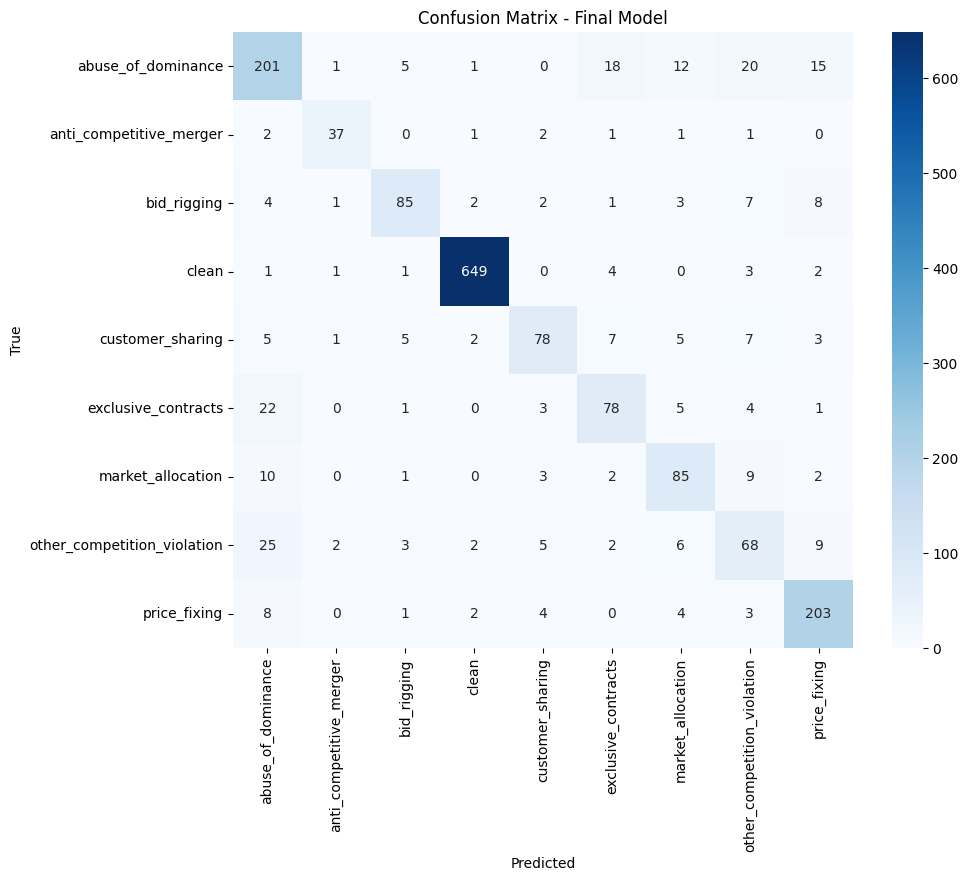

In [15]:
# -----------------------------
# 7️⃣ Test setinde değerlendirme
# -----------------------------
test_logits = trainer_final.predict(test_ds).predictions
test_preds  = np.argmax(test_logits, axis=-1)
test_true   = [label2id[l] for l in test_labels]

# Confusion matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Final Model")
plt.show()

# Brief analysis of class imbalance and potential data leakage risks

# Backend-Ready Simple

Girdi: 

    e-posta subject ve body (veya sadece text)

Çıktı:

    label → modelin tahmin ettiği sınıf

    confidence → modelin tahmine olan güveni

In [ ]:
def predict_email(subject, body, model, tokenizer):
    """
    E-posta subject ve body'sini sınıflandırır
    
    Args:
        subject (str): E-posta konusu
        body (str): E-posta içeriği
        model: Fine tune edilmiş model
        tokenizer: Model ile uyumlu tokenizer
    
    Returns:
        dict: label ve confidence içeren sözlük
    """
    text = subject + " " + body
    
    # Tokenize et ve modelin bulunduğu device'a gönder
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    model.eval()  # Evaluation moduna al
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)
        label_id = torch.argmax(probs, dim=-1).item()
        confidence = probs[0, label_id].item()
    
    return {"label": id2label[label_id], "confidence": confidence}



In [18]:
# Fine tune edilmiş modeli yükle (en son checkpoint'ı kullan)
model_path = "../models/trained_model2/checkpoint-3111"  # En son checkpoint
model_final = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Modeli GPU'ya taşı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_final.to(device)
print(f"Model {device} üzerinde yüklendi ve hazır.")

# Test etmek için örnek tahmin
result = predict_email("Fiyatlandırma Üzerine Görüşme Talebi", "Merhaba Emre Bey, Yarın fiyatlandırma üzerine kısa bir toplantı yapmayı öneriyorum. Uygun olduğunuz saatleri paylaşmanızı rica eder, İyi çalışmalar dilerim. Saygılarımla, Elif Beyza Tok", model_final, tokenizer)
print(f"Tahmin: {result['label']}")
print(f"Güven skoru: {result['confidence']:.4f}")

Model cuda üzerinde yüklendi ve hazır.
Tahmin: price_fixing
Güven skoru: 0.9952
